# 泰坦尼克号幸存者预测问题

## 读取数据

In [159]:
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [160]:
# 为了简单起见，先使用中位数填充，后面我们有更合理的填充年龄缺失数据的方法


In [164]:
314 + 577

891

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


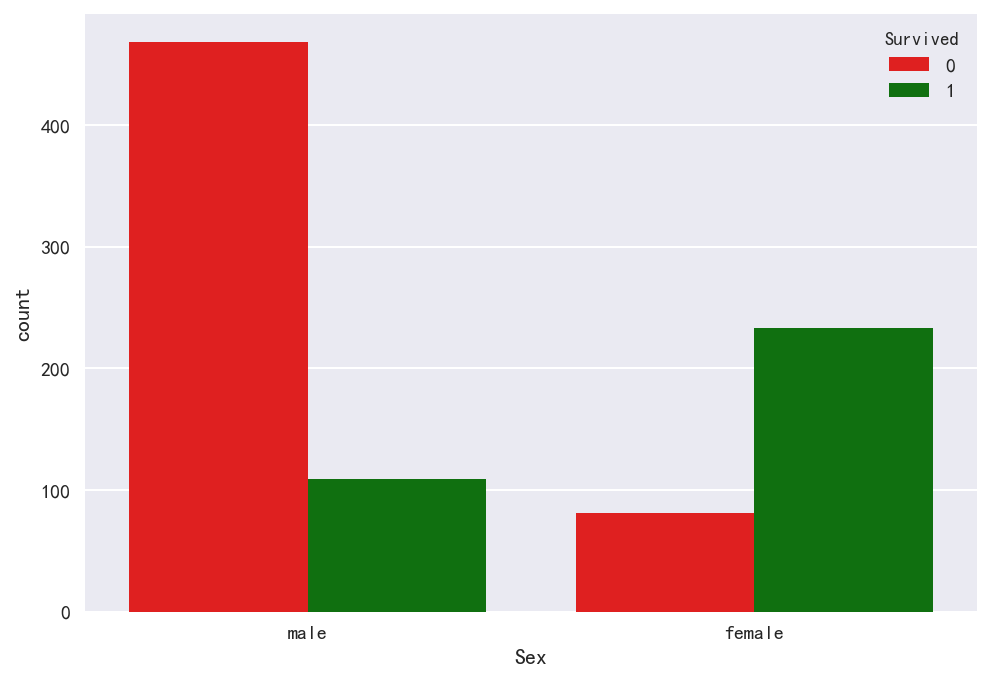

### 猜测：票价和幸存有关

我们的常识告诉我们票价越高，所在的环境人越少，获救的可能性越大。

票价是连续型变量，所以可以画箱线图，看看分布。

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


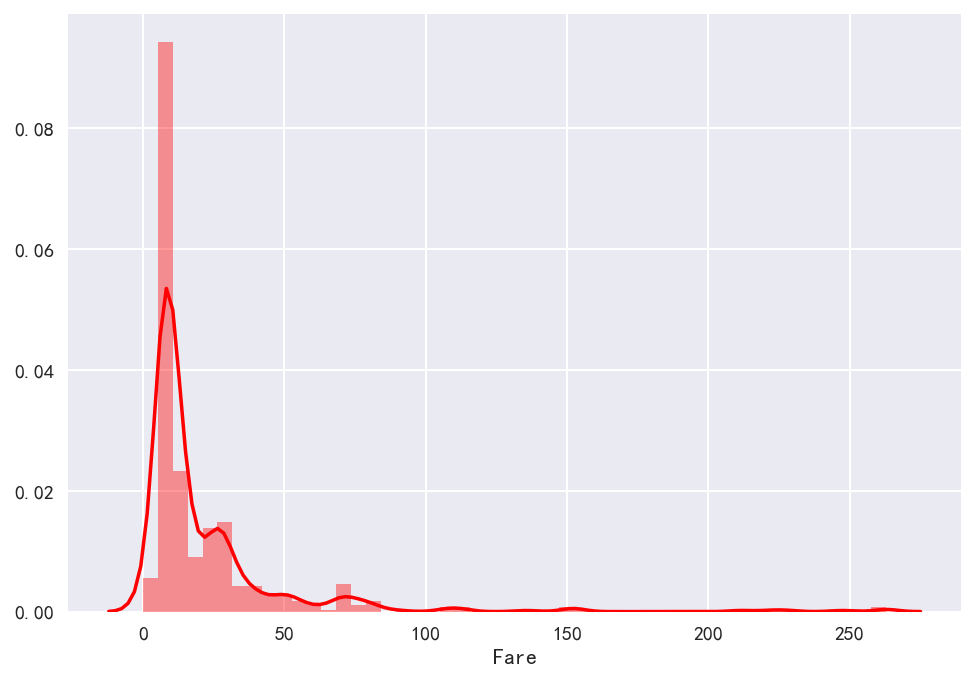

In [209]:
plt.figure()

dd

### 猜测：乘客等级 Pclass 对是否幸存有影响

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


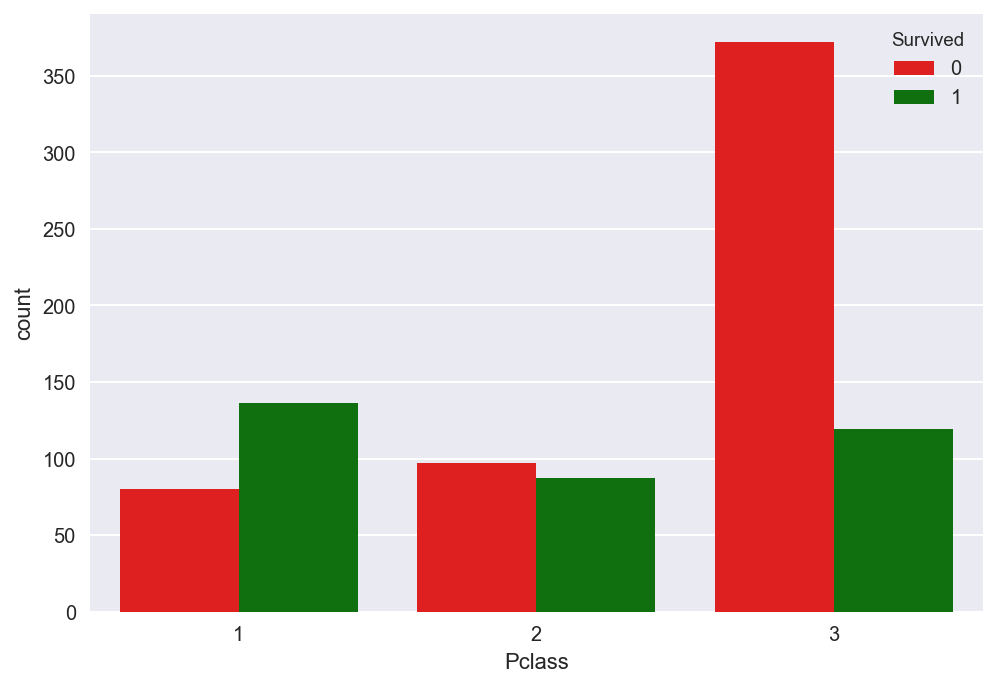

(102.88898875696056,
 4.549251711298793e-23,
 2,
 array([[133.09090909,  82.90909091],
        [113.37373737,  70.62626263],
        [302.53535354, 188.46464646]]))

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


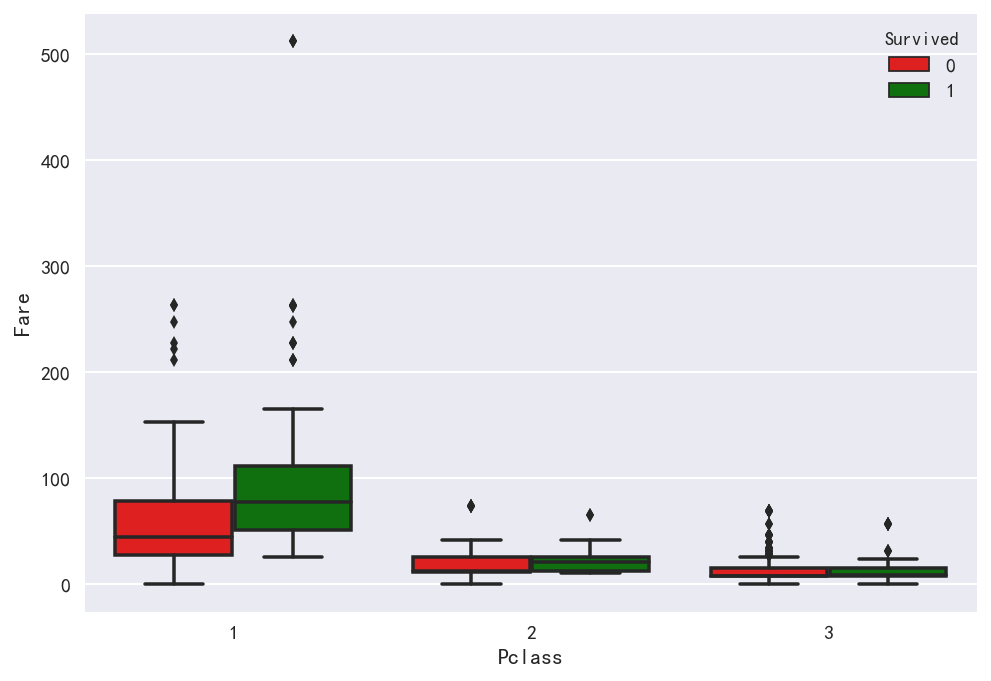

### 猜测：登船港口 Embarked 对是否幸存有影响

array(['S', 'C', 'Q', nan], dtype=object)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


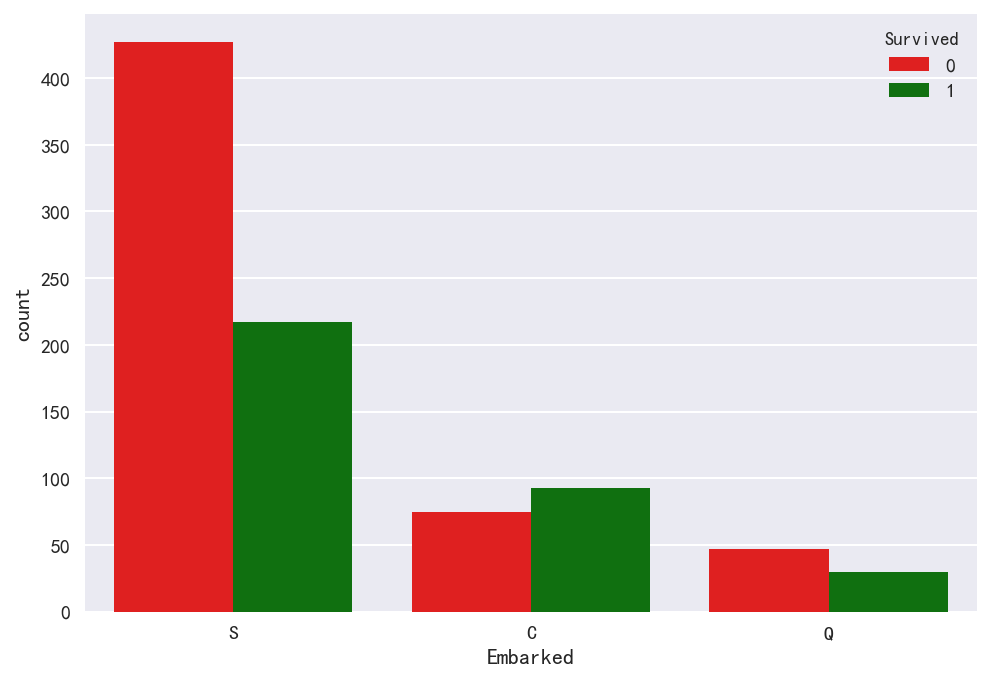

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


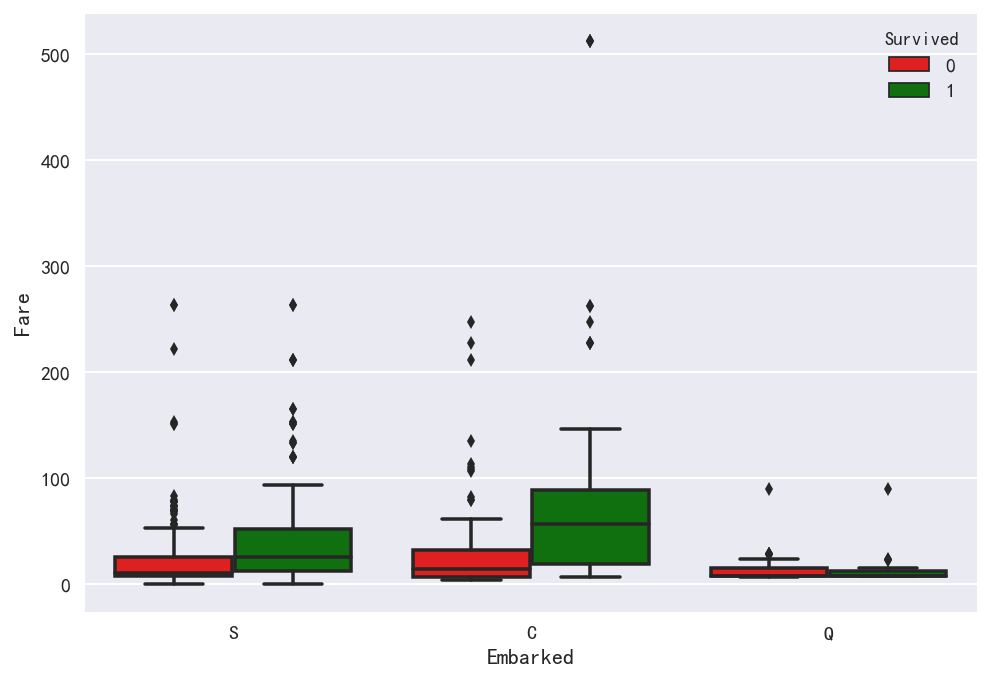

In [114]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Died'],
      dtype='object')

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


(26.48914983923762,
 1.769922284120912e-06,
 2,
 array([[103.7480315,  64.2519685],
        [ 47.5511811,  29.4488189],
        [397.7007874, 246.2992126]]))

以上我们做的工作就是提出我们的猜想，根据一些数学工具，或者绘图验证我们的猜想，我们的猜想无非就是哪些特征重要、哪些特征不重要。

我们总结一下：

重要的特征有：
1、性别 Sex

2、年龄（可能比较重要） Age

3、票价 Fare

4、乘客等级 Pclass

5、登船港口 Embarked


我个人觉得刚开始做这部分工作的时候，不要纠结在怎么绘图上，其实绘图好坏对最终的模型训练没有什么实质上的帮助，绘图绘制得好，会让你的分析更有说服力。


重点其实在下面这一步：<span class="burk">特征工程</span>。特征工程的操作实实在在影响到最终模型运行的结果。

## 特征工程

我们首先把训练数据集和测试数据集合并起来。

这里要注意：真实的项目是不可以这么做的，因为真实的项目中我们是拿不到测试数据集的。这里这么做只是为了把测试数据集和训练数据集放在一起处理。

In [122]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [128]:
train.shape, test.shape

((891, 12), (418, 11))

In [129]:
train.shape[0], test.shape[0]

(891, 418)

In [132]:
# combined = train.append(test)

(1309, 12)

(1309, 10)

### 步骤1：从姓名中抽取 title 特征

我们发现姓名里面有 title，title 可能是社会地位的象征，根据这一点，抽取特征

分成六个类。

### 处理缺失的年龄特征

先分别看一看年龄在训练数据集和测试数据集中缺失了多少。

In [456]:
# 训练数据集中年龄缺失个数
print(combined_data.iloc[:891].Age.isnull().sum())

177


In [457]:
# 测试数据集中年龄缺失个数
print(combined_data.iloc[891:].Age.isnull().sum())

86


可以看到，训练数据集有 177 个缺失值，测试数据集有 86 个缺失值。

下面我们要编写一个函数，即根据一条数据的 “性别”、“客舱” 和 “Title” 到上面的 `grouped_median_train` 中查询对应的值。

+ 。

In [464]:
# 'Age' 列填充完成
combined_data.describe()

,Pclass,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
count,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,29.213270,0.498854,0.385027,33.295479,0.046600,0.200153,0.578304,0.153552,0.017571,0.003820
std,0.837836,13.400994,1.041658,0.865560,51.758668,0.210862,0.400267,0.494019,0.360657,0.131435,0.061709
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,36.500000,1.000000,0.000000,31.275000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [479]:
del combined_data['Embarked']

### 处理 Cabin

In [480]:
combined_data['Cabin']

0               NaN
1               C85
2               NaN
3              C123
4               NaN
5               NaN
6               E46
7               NaN
8               NaN
9               NaN
10               G6
11             C103
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19              NaN
20              NaN
21              D56
22              NaN
23               A6
24              NaN
25              NaN
26              NaN
27      C23 C25 C27
28              NaN
29              NaN
           ...     
1279            NaN
1280            NaN
1281            B24
1282            D28
1283            NaN
1284            NaN
1285            NaN
1286            C31
1287            NaN
1288            B41
1289            NaN
1290            NaN
1291             C7
1292            NaN
1293            NaN
1294            NaN
1295            D40
1296            D38
1297            NaN


看似杂乱无章呀。不过排个序看一看。

In [481]:
combined_data['Cabin'].sort_values()

583      A10
1099     A11
475      A14
556      A16
1222     A18
284      A19
599      A20
919      A21
630      A23
867      A24
647      A26
1003     A29
209      A31
185      A32
1184     A34
1265     A34
445      A34
806      A36
96        A5
23        A6
174       A7
937       A9
1057     B10
737     B101
815     B102
1106     B11
523      B18
329      B18
170      B19
781      B20
        ... 
1268     NaN
1270     NaN
1271     NaN
1272     NaN
1273     NaN
1274     NaN
1275     NaN
1276     NaN
1277     NaN
1278     NaN
1279     NaN
1280     NaN
1283     NaN
1284     NaN
1285     NaN
1287     NaN
1289     NaN
1290     NaN
1292     NaN
1293     NaN
1294     NaN
1297     NaN
1299     NaN
1300     NaN
1301     NaN
1303     NaN
1304     NaN
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

In [482]:
combined_data.Cabin.shape

(1309,)

In [483]:
combined_data.Cabin.value_counts().sum()

295

In [484]:
combined_data.shape

(1309, 18)

In [485]:
combined_data[combined_data.Cabin.isnull()].shape

(1014, 18)

缺失很多。

In [486]:
295 + 1014

1309

把缺失的都填充成 `U` ，就是 `unknown` 的意思。

In [487]:
combined_data['Cabin'].fillna('U', inplace=True)

In [488]:
combined_data['Cabin'] = combined_data['Cabin'].map(lambda x: x[0])
combined_data['Cabin']

0       U
1       C
2       U
3       C
4       U
5       U
6       E
7       U
8       U
9       U
10      G
11      C
12      U
13      U
14      U
15      U
16      U
17      U
18      U
19      U
20      U
21      D
22      U
23      A
24      U
25      U
26      U
27      C
28      U
29      U
       ..
1279    U
1280    U
1281    B
1282    D
1283    U
1284    U
1285    U
1286    C
1287    U
1288    B
1289    U
1290    U
1291    C
1292    U
1293    U
1294    U
1295    D
1296    D
1297    U
1298    C
1299    U
1300    U
1301    U
1302    C
1303    U
1304    U
1305    C
1306    U
1307    U
1308    U
Name: Cabin, Length: 1309, dtype: object

In [489]:
combined_data['Cabin'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [491]:
del combined_data['Cabin']

### 处理性别，因为是二值数据，直接使用 1 和 0 替换即可

In [494]:
combined_data = pd.concat([combined_data, Pclass_dummies], axis=1)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title,Title_Master,Title_Miss,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,3,1,22.0,1,0,A/5 21171,7.2500,Mr,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,Mrs,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,Miss,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,35.0,1,0,113803,53.1000,Mrs,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3,1,35.0,0,0,373450,8.0500,Mr,0,0,...,0,0,0,0,0,0,1,0,0,1


### 处理 Ticket

为了简化，暂时不处理了，认为这是一个无效的特征。实际上还是有高手，从票价信息中，分析出了有用的特征。

In [495]:
combined_data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

### 从 SibSp 和 Parch 中抽取出新特征“家庭规模”

我们人为划定一个家庭规模标准。

## 建模

In [512]:
combined_data.shape

(1309, 29)

### 分离训练数据集和验证数据集

### 使用随机森林得到特征的重要程度

### 使用 SelectFromModel 这个类找到重要的特征

注意：这个类来自特征选择。

> Meta-transformer for selecting features based on importance weights.

(891, 7)

In [564]:
np.set_printoptions(linewidth=100, suppress=True)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.nan)
train_reduced

array([[  1.    ,  22.    ,   7.25  ,   0.    ,   1.    ,   0.    ,   1.    ],
       [  0.    ,  38.    ,  71.2833,   0.    ,   0.    ,   1.    ,   0.    ],
       [  0.    ,  26.    ,   7.925 ,   1.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  35.    ,  53.1   ,   0.    ,   0.    ,   1.    ,   0.    ],
       [  1.    ,  35.    ,   8.05  ,   0.    ,   1.    ,   0.    ,   1.    ],
       [  1.    ,  26.    ,   8.4583,   0.    ,   1.    ,   0.    ,   1.    ],
       [  1.    ,  54.    ,  51.8625,   0.    ,   1.    ,   0.    ,   0.    ],
       [  1.    ,   2.    ,  21.075 ,   0.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  27.    ,  11.1333,   0.    ,   0.    ,   1.    ,   1.    ],
       [  0.    ,  14.    ,  30.0708,   0.    ,   0.    ,   1.    ,   0.    ],
       [  0.    ,   4.    ,  16.7   ,   1.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  58.    ,  26.55  ,   1.    ,   0.    ,   0.    ,   0.    ],
       [  1.    ,  20.    ,   8.05  ,   0.    ,   1.

### 得到的重要的特征以后，我们就要把数据送入算法了

我们没有调参，使用默认的参数。

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.7833894500561168
******
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.7822671156004489
******
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.809203142536476
******
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8159371492704826
******


In [574]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()
score = cross_val_score(estimator=xgboost_clf, X=train_reduced, y=y_train, scoring='accuracy')
print(score.mean())

0.8294051627384961


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 使用网格搜索对随机森林调参